In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [238]:

def plot_candles(pricing, title=None, volume_bars=False, color_function=None, technicals=None):
    
    def default_color(index, open_price, close_price, low, high):
       # return 'r' if open_price[index] > close_price[index] else 'g'
        if abs(open_price[index]-close_price[index])<=0.5*(high[index]-low[index]):
            return 'b'
        elif open_price[index] - close_price[index] > 0 :
            return 'r'
        elif open_price[index] - close_price[index] <= 0:
            return 'g'
        else: 
            print('Return')
    
    color_function = color_function or default_color
    technicals = technicals or []
    open_price = pricing['Open']
    close_price = pricing['Close']
    low = pricing['Low']
    high = pricing['High']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
    
    if volume_bars:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]}, figsize=(15,6))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
    if title:
        ax1.set_title(title)
    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x, low, high, color=candle_colors, linewidth=1)
    ax1.xaxis.grid(False)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    # Assume minute frequency if first two bars are in the same day.
    frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
    time_format = '%Y-%m-%d'
    if frequency == 'minute':
        time_format = '%H:%M'
    # Set X axis tick labels.
    plt.xticks(x, [date.strftime(time_format) for date in pricing.index], rotation='vertical')
    for indicator in technicals:
        ax1.plot(x, indicator)
    
    if volume_bars:
        volume = pricing['Volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors)
        volume_title = 'Volume'
        if volume_scale:
            volume_title = 'Volume (%s)' % volume_scale
        ax2.set_title(volume_title)
        ax2.xaxis.grid(False)

In [170]:
import os

In [312]:
hdfc = pd.read_csv('hdfc.csv')
hdfc['Date'] = hdfc['Date'].apply(pd.to_datetime)
hdfc.set_index('Date',inplace=True)

In [173]:
hdfc

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-03,2004.000000,2032.449951,1997.150024,2013.099976,1982.898438,4345772.0
2019-04-04,2008.000000,2058.800049,2006.300049,2042.050049,2011.414185,4463212.0
2019-04-05,2045.000000,2065.000000,2035.000000,2059.199951,2028.306885,2576789.0
2019-04-08,2068.000000,2072.500000,2029.250000,2054.899902,2024.071411,2057768.0
2019-04-09,2062.500000,2073.000000,2039.150024,2069.149902,2038.107544,2381281.0
...,...,...,...,...,...,...
2020-03-26,1689.500000,1843.449951,1671.199951,1733.250000,1733.250000,12104338.0
2020-03-27,1785.199951,1849.650024,1710.050049,1754.000000,1754.000000,9048364.0
2020-03-30,1667.300049,1699.000000,1548.000000,1558.750000,1558.750000,8670676.0


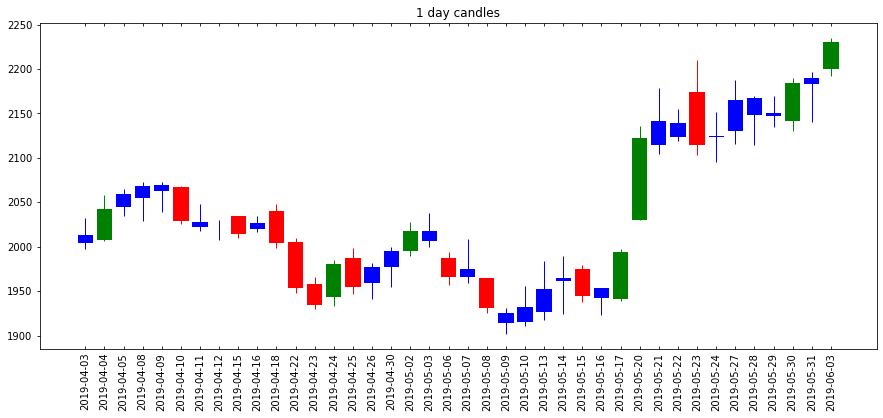

In [245]:
plot_candles(hdfc[:40], title='1 day candles')

In [284]:
hdfc['High'][7]

2029.9000239999998

In [283]:
pricing = hdfc
open_price = pricing['Open']
close_price = pricing['Close']
low = pricing['Low']
high = pricing['High']
typ = np.ones(len(pricing['Low']))

for index in range(len(pricing['Open'])):
    if abs(open_price[index]-close_price[index])<=0.5*(high[index]-low[index]):
        typ[index]=0
    elif open_price[index] - close_price[index] > 0 :
        typ[index]=-1
    elif open_price[index] - close_price[index] <= 0:
        typ[index]=1
typ

pricing['Type'] = typ

In [305]:
# Identifying Pattern
# Categorization
# Long - DBR RBR  Short - RBD DBD

typ = hdfc['Type']

def rbr(nums):
  # Note: iterate with length-2, so can use i+1 and i+2 in the loop
    a=[]
    for i in range(len(nums)-2):
        if nums[i]==1 and nums[i+1]==0 and nums[i+2]==1:
            a.append(i)
    return a

def dbd(nums):
  # Note: iterate with length-2, so can use i+1 and i+2 in the loop
    a=[]
    for i in range(len(nums)-2):
        if nums[i]==-1 and nums[i+1]==0 and nums[i+2]==-1:
            a.append(i)
    return a

def dbr(nums):
  # Note: iterate with length-2, so can use i+1 and i+2 in the loop
    a=[]
    for i in range(len(nums)-2):
        if nums[i]==-1 and nums[i+1]==0 and nums[i+2]==1:
            a.append(i)
    return a

def rbd(nums):
  # Note: iterate with length-2, so can use i+1 and i+2 in the loop
    a=[]
    for i in range(len(nums)-2):
        if nums[i]==1 and nums[i+1]==0 and nums[i+2]==-1:
            a.append(i)
    return a

b=rbr(typ)
c=dbd(typ)
d=dbr(typ)
e=rbd(typ)
d
# Freshness
# Strength
# 

[26, 48, 81, 111, 152, 184, 196, 227]

In [308]:

def plot_candles(pricing, title=None, volume_bars=False, color_function=None, technicals=None):
    
    def default_color(index, open_price, close_price, low, high):
       # return 'r' if open_price[index] > close_price[index] else 'g'
        if abs(open_price[index]-close_price[index])<=0.5*(high[index]-low[index]):
            return 'b'
        elif open_price[index] - close_price[index] > 0 :
            return 'r'
        elif open_price[index] - close_price[index] <= 0:
            return 'g'
        else: 
            print('Return')
    
    color_function = color_function or default_color
    technicals = technicals or []
    open_price = pricing['Open']
    close_price = pricing['Close']
    low = pricing['Low']
    high = pricing['High']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
    typ = np.ones(len(pricing['Low']))

    for index in range(len(pricing['Open'])):
        if abs(open_price[index]-close_price[index])<=0.5*(high[index]-low[index]):
            typ[index]=0
        elif open_price[index] - close_price[index] > 0 :
            typ[index]=-1
        elif open_price[index] - close_price[index] <= 0:
            typ[index]=1
   #pricing['Type'] = typ

    def rbd(nums):
      # Note: iterate with length-2, so can use i+1 and i+2 in the loop
    a=[]
        for i in range(len(nums)-2):
            if nums[i]==1 and nums[i+1]==0 and nums[i+2]==-1:
                a.append(i)
        return a
    def dbr(nums):
      # Note: iterate with length-2, so can use i+1 and i+2 in the loop
        a=[]
        for i in range(len(nums)-2):
            if nums[i]==-1 and nums[i+1]==0 and nums[i+2]==1:
                a.append(i)
        return a
    

    
    #Drawing
    if volume_bars:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]}, figsize=(15,6))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
    if title:
        ax1.set_title(title)
    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x, low, high, color=candle_colors, linewidth=1)
    ax1.xaxis.grid(False)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    
    
    rallybasedrop=rbd(typ)
    for i in range(len(rallybasedrop)):
        pattern_first=rallybasedrop[i]
        #Single Base Candle
        outer_point=pricing['High'][pattern_first+1]

        if pricing['Open'][pattern_first+1]>pricing['Close'][pattern_first+1]:
            inner_point=pricing['Close'][pattern_first+1]
        elif pricing['Close'][pattern_first+1]>=pricing['Open'][pattern_first+1]:
            inner_point=pricing['Open'][pattern_first+1]
        plt.axhline(y=inner_point, color='r')
        plt.axhline(y=outer_point, color='r')    

    dropbaserally=dbr(typ)
    for i in range(len(dropbaserally)):
        pattern_first=dropbaserally[i]
        #Single Base Candle
        outer_point=pricing['Low'][pattern_first+1]

        if pricing['Open'][pattern_first+1]>pricing['Close'][pattern_first+1]:
            inner_point=pricing['Open'][pattern_first+1]
        elif pricing['Close'][pattern_first+1]>=pricing['Open'][pattern_first+1]:
            inner_point=pricing['Close'][pattern_first+1]
        plt.axhline(y=inner_point, color='g')
        plt.axhline(y=outer_point, color='g')    
    
    # Assume minute frequency if first two bars are in the same day.
    frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
    time_format = '%Y-%m-%d'
    if frequency == 'minute':
        time_format = '%H:%M'
    # Set X axis tick labels.
    plt.xticks(x, [date.strftime(time_format) for date in pricing.index], rotation='vertical')
    for indicator in technicals:
        ax1.plot(x, indicator)
    
    
    # Volume
    if volume_bars:
        volume = pricing['Volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors)
        volume_title = 'Volume'
        if volume_scale:
            volume_title = 'Volume (%s)' % volume_scale
        ax2.set_title(volume_title)
        ax2.xaxis.grid(False)
    return pricing

IndentationError: expected an indented block (<ipython-input-308-2e7d824cad2d>, line 35)

,Open,High,Low,Close,Adj Close,Volume,Type
Date,,,,,,,
2020-02-18,2349.000000,2349.000000,2304.000000,2318.800049,2318.800049,2345063.0,-1.0
2020-02-19,2343.000000,2385.000000,2330.050049,2377.250000,2377.250000,2088724.0,1.0
2020-02-20,2364.000000,2377.500000,2349.050049,2369.500000,2369.500000,3351611.0,0.0
2020-02-24,2355.000000,2365.199951,2280.100098,2292.300049,2292.300049,4238039.0,-1.0
2020-02-25,2309.000000,2320.750000,2285.000000,2302.600098,2302.600098,3292922.0,0.0
2020-02-26,2278.000000,2309.500000,2253.550049,2281.449951,2281.449951,6163133.0,0.0
2020-02-27,2279.800049,2289.600098,2244.550049,2272.199951,2272.199951,3261885.0,0.0
2020-02-28,2228.550049,2228.550049,2162.300049,2175.750000,2175.750000,7715143.0,-1.0
2020-03-02,2215.000000,2248.350098,2153.800049,2179.649902,2179.649902,3957634.0,0.0


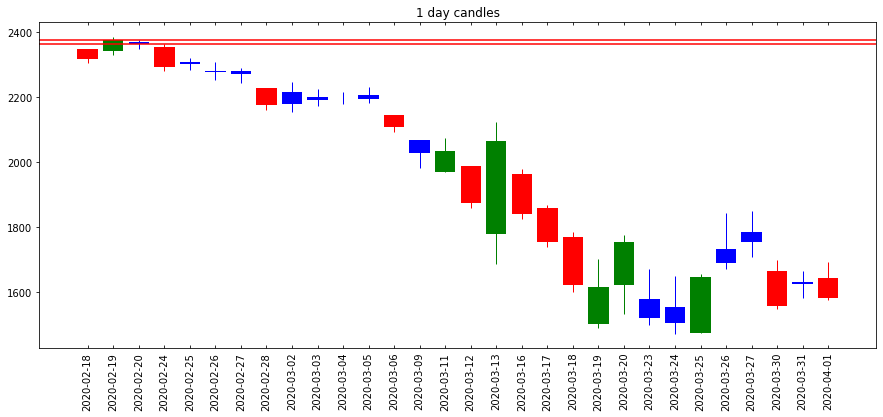

In [299]:
plot_candles(hdfc[-30:], title='1 day candles')

In [309]:

def plot_candles(pricing, title=None, volume_bars=False, color_function=None, technicals=None):
    
    def default_color(index, open_price, close_price, low, high):
       # return 'r' if open_price[index] > close_price[index] else 'g'
        if abs(open_price[index]-close_price[index])<=0.5*(high[index]-low[index]):
            return 'b'
        elif open_price[index] - close_price[index] > 0 :
            return 'r'
        elif open_price[index] - close_price[index] <= 0:
            return 'g'
        else: 
            print('Return')
    
    color_function = color_function or default_color
    technicals = technicals or []
    open_price = pricing['Open']
    close_price = pricing['Close']
    low = pricing['Low']
    high = pricing['High']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
    typ = np.ones(len(pricing['Low']))

    for index in range(len(pricing['Open'])):
        if abs(open_price[index]-close_price[index])<=0.5*(high[index]-low[index]):
            typ[index]=0
        elif open_price[index] - close_price[index] > 0 :
            typ[index]=-1
        elif open_price[index] - close_price[index] <= 0:
            typ[index]=1
   #pricing['Type'] = typ

    def rbd(nums):
      # Note: iterate with length-2, so can use i+1 and i+2 in the loop
        a=[]
        for i in range(len(nums)-2):
            if nums[i]==1 and nums[i+1]==0 and nums[i+2]==-1:
                a.append(i)
        return a
    def dbr(nums):
  # Note: iterate with length-2, so can use i+1 and i+2 in the loop
        a=[]
        for i in range(len(nums)-2):
            if nums[i]==-1 and nums[i+1]==0 and nums[i+2]==1:
                a.append(i)
        return a


    
    #Drawing
    if volume_bars:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]}, figsize=(15,6))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
    if title:
        ax1.set_title(title)
    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x, low, high, color=candle_colors, linewidth=1)
    ax1.xaxis.grid(False)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    
    
    rallybasedrop=rbd(typ)
    for i in range(len(rallybasedrop)):
        pattern_first=rallybasedrop[i]
        #Single Base Candle
        outer_point=pricing['High'][pattern_first+1]

        if pricing['Open'][pattern_first+1]>pricing['Close'][pattern_first+1]:
            inner_point=pricing['Close'][pattern_first+1]
        elif pricing['Close'][pattern_first+1]>=pricing['Open'][pattern_first+1]:
            inner_point=pricing['Open'][pattern_first+1]
        plt.axhline(y=inner_point, color='r')
        plt.axhline(y=outer_point, color='r')    
        
    dropbaserally=dbr(typ)
    for i in range(len(dropbaserally)):
        pattern_first=dropbaserally[i]
        #Single Base Candle
        outer_point=pricing['Low'][pattern_first+1]

        if pricing['Open'][pattern_first+1]>pricing['Close'][pattern_first+1]:
            inner_point=pricing['Open'][pattern_first+1]
        elif pricing['Close'][pattern_first+1]>=pricing['Open'][pattern_first+1]:
            inner_point=pricing['Close'][pattern_first+1]
        plt.axhline(y=inner_point, color='g')
        plt.axhline(y=outer_point, color='g')    
    
    # Assume minute frequency if first two bars are in the same day.
    frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
    time_format = '%Y-%m-%d'
    if frequency == 'minute':
        time_format = '%H:%M'
    # Set X axis tick labels.
    plt.xticks(x, [date.strftime(time_format) for date in pricing.index], rotation='vertical')
    for indicator in technicals:
        ax1.plot(x, indicator)
    
    
    # Volume
    if volume_bars:
        volume = pricing['Volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors)
        volume_title = 'Volume'
        if volume_scale:
            volume_title = 'Volume (%s)' % volume_scale
        ax2.set_title(volume_title)
        ax2.xaxis.grid(False)
    return pricing

,Open,High,Low,Close,Adj Close,Volume,Type
Date,,,,,,,
2020-02-18,2349.000000,2349.000000,2304.000000,2318.800049,2318.800049,2345063.0,-1.0
2020-02-19,2343.000000,2385.000000,2330.050049,2377.250000,2377.250000,2088724.0,1.0
2020-02-20,2364.000000,2377.500000,2349.050049,2369.500000,2369.500000,3351611.0,0.0
2020-02-24,2355.000000,2365.199951,2280.100098,2292.300049,2292.300049,4238039.0,-1.0
2020-02-25,2309.000000,2320.750000,2285.000000,2302.600098,2302.600098,3292922.0,0.0
2020-02-26,2278.000000,2309.500000,2253.550049,2281.449951,2281.449951,6163133.0,0.0
2020-02-27,2279.800049,2289.600098,2244.550049,2272.199951,2272.199951,3261885.0,0.0
2020-02-28,2228.550049,2228.550049,2162.300049,2175.750000,2175.750000,7715143.0,-1.0
2020-03-02,2215.000000,2248.350098,2153.800049,2179.649902,2179.649902,3957634.0,0.0


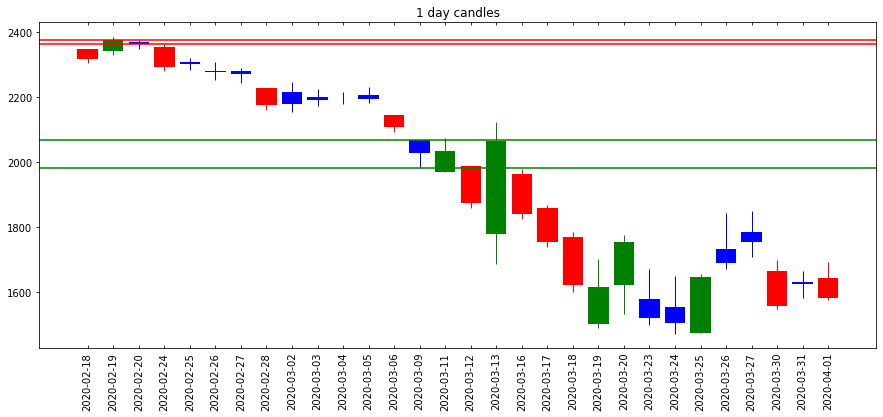

In [311]:
plot_candles(hdfc[-30:], title='1 day candles')

In [316]:
dlf = pd.read_csv('DLFNX.csv')
def set_ready(scrip):
    scrip['Date'] = scrip['Date'].apply(pd.to_datetime)
    scrip.set_index('Date',inplace=True)
    return scrip
dlf = set_ready(dlf)
dlf

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-04,11.38,11.38,11.38,11.38,11.38,0.0
2020-03-05,11.41,11.41,11.41,11.41,11.41,0.0
2020-03-06,11.45,11.45,11.45,11.45,11.45,0.0
2020-03-09,11.41,11.41,11.41,11.41,11.41,0.0
2020-03-10,11.29,11.29,11.29,11.29,11.29,0.0
2020-03-11,11.22,11.22,11.22,11.22,11.22,0.0
2020-03-12,11.09,11.09,11.09,11.09,11.09,0.0
2020-03-13,11.01,11.01,11.01,11.01,11.01,0.0
2020-03-16,10.99,10.99,10.99,10.99,10.99,0.0
